##Let's now use this data to make a model that can predict the likelihood of "trouble" for a given loan. Trouble will be defined as any loan_status not current or fully paid.

In [1]:
!pip install xgboost
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
df_subset = pd.read_csv('../../Resources/df_subset.csv')

In [ ]:
df_subset.loan_status.value_counts()

loan_status
Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: count, dtype: int64

In [ ]:
#✅ Step 1: Define the Target – “Trouble”

df_subset['loan_status_cleaned'] = df_subset['loan_status'].replace({
    'Does not meet the credit policy. Status:Fully Paid': 'Fully Paid',
    'Does not meet the credit policy. Status:Charged Off': 'Charged Off'
})

def label_trouble(status):
    if status in ['Charged Off', 'Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period']:
        return 1
    else:
        return 0

df_subset['trouble'] = df_subset['loan_status_cleaned'].apply(label_trouble)


In [ ]:
print(df_subset.trouble.value_counts())

trouble
0    1963635
1     297033
Name: count, dtype: int64


In [ ]:
#Step 2: Drop Leaky or Useless Features
df_model2 = df_subset.drop(columns=['loan_status', 'loan_status_cleaned'])

In [ ]:
X = df_model2.drop(columns=['trouble'])
y = df_model2['trouble']

In [ ]:
#Step 3: Encode Categoricals
X = pd.get_dummies(X, drop_first=True)

In [ ]:
#Step 4: Handle Missing Values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)


In [ ]:
#Step 5: Train/Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, stratify=y, random_state=42
)


In [ ]:
#Step 6: Address Imbalance

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)


c:\Users\jitra\anaconda3\envs\dev\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\jitra\anaconda3\envs\dev\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\jitra\anaconda3\envs\dev\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\jitra\anaconda3\envs\dev\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\jitra\anaconda3\envs\dev\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


In [ ]:
#Step 7: Scale Features

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)


In [ ]:
#Step 8: Train Model

model = XGBClassifier(
    n_estimators=150,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(X_train_scaled, y_train_bal)


c:\Users\jitra\anaconda3\envs\dev\lib\site-packages\xgboost\training.py:183: UserWarning: [21:27:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
#Step 9: Evaluate the Model

y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


[[391670   1057]
 [ 58281   1126]]
              precision    recall  f1-score   support

           0       0.87      1.00      0.93    392727
           1       0.52      0.02      0.04     59407

    accuracy                           0.87    452134
   macro avg       0.69      0.51      0.48    452134
weighted avg       0.82      0.87      0.81    452134

ROC AUC: 0.7495117653266963


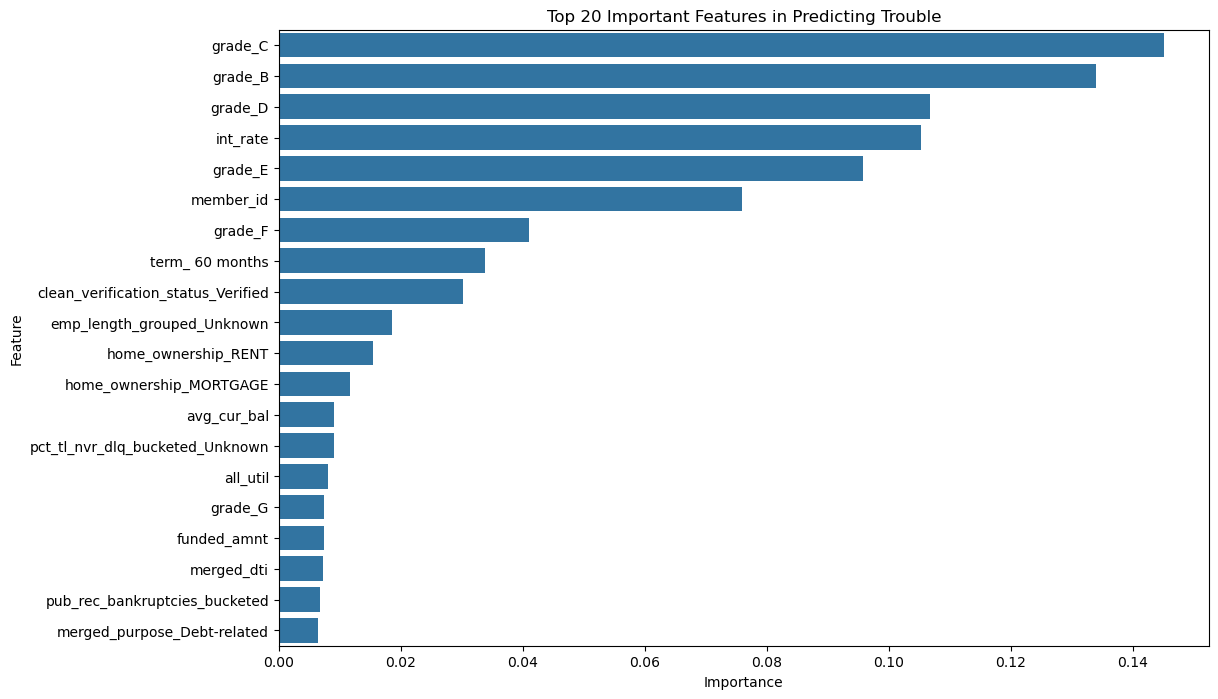

In [ ]:
#Step 10: Feature Importance

importances = model.feature_importances_
feat_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feat_df.head(20))
plt.title('Top 20 Important Features in Predicting Trouble')
plt.show()


So, our model is very good at predicting non-risky loans but incapable of predicting risky loans, which is NOT what we want. We must adress class imbalance!

c:\Users\jitra\anaconda3\envs\dev\lib\site-packages\xgboost\training.py:183: UserWarning: [21:38:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[[249240 143487]
 [ 15898  43509]]
              precision    recall  f1-score   support

           0       0.94      0.63      0.76    392727
           1       0.23      0.73      0.35     59407

    accuracy                           0.65    452134
   macro avg       0.59      0.68      0.56    452134
weighted avg       0.85      0.65      0.70    452134

ROC AUC: 0.7509078624898229


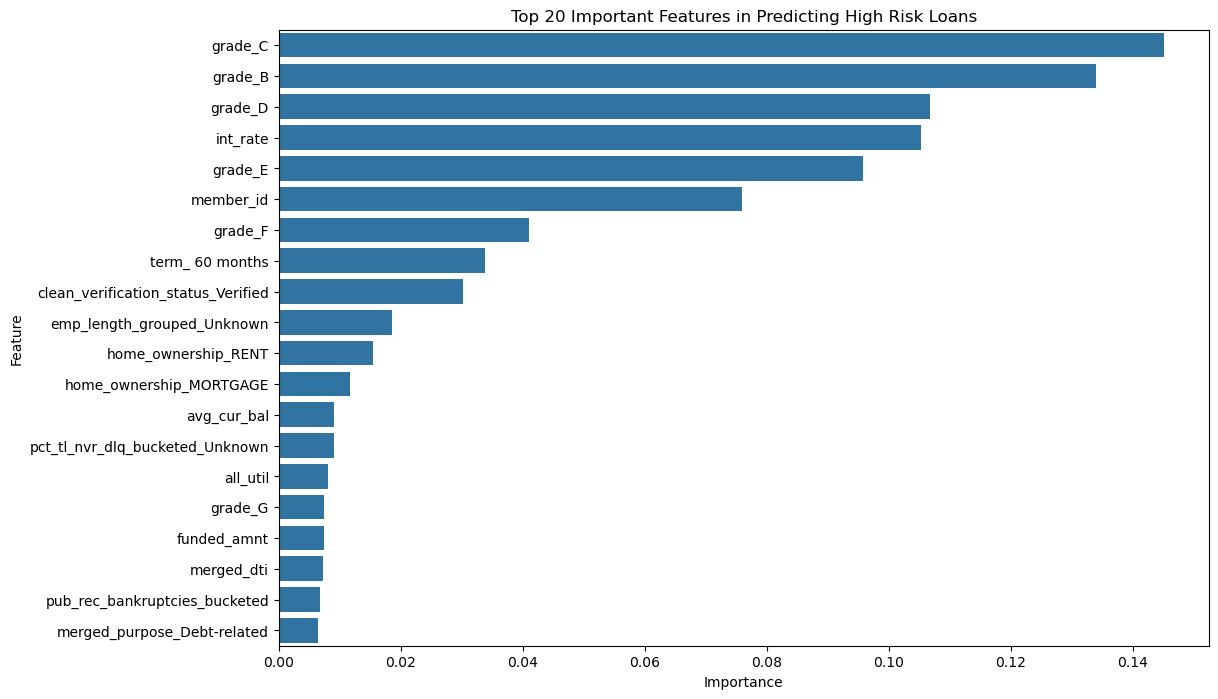

In [ ]:
#Let's try class weights to see if this can better address the imbalance issue

# Modify Class Weights
# Using XGBoost's `scale_pos_weight` parameter
# `scale_pos_weight` is set as (number of majority class samples / number of minority class samples)
from collections import Counter

class_counts = Counter(y_train)  # Count instances of each class
scale_pos_weight = class_counts[0] / class_counts[1]  # Adjust weight for minority class

# Step 7: Scale Features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 8: Train Model
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=150,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight  # Incorporate class weights
)

model.fit(X_train_scaled, y_train)

# Step 9: Evaluate the Model
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Step 10: Feature Importance

importances = model.feature_importances_
feat_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feat_df.head(20))
plt.title('Top 20 Important Features in Predicting High Risk Loans')
plt.show()

[LightGBM] [Info] Number of positive: 237626, number of negative: 1570908
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.137572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2894
[LightGBM] [Info] Number of data points in the train set: 1808534, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[[248788 143939]
 [ 15816  43591]]
              precision    recall  f1-score   support

           0       0.94      0.63      0.76    392727
           1       0.23      0.73      0.35     59407

    accuracy                           0.65    452134
   macro avg       0.59      0.68      0.56    452134
weighted avg       0.85      0.65      0.70    452134

ROC AUC: 0.7508059542466781


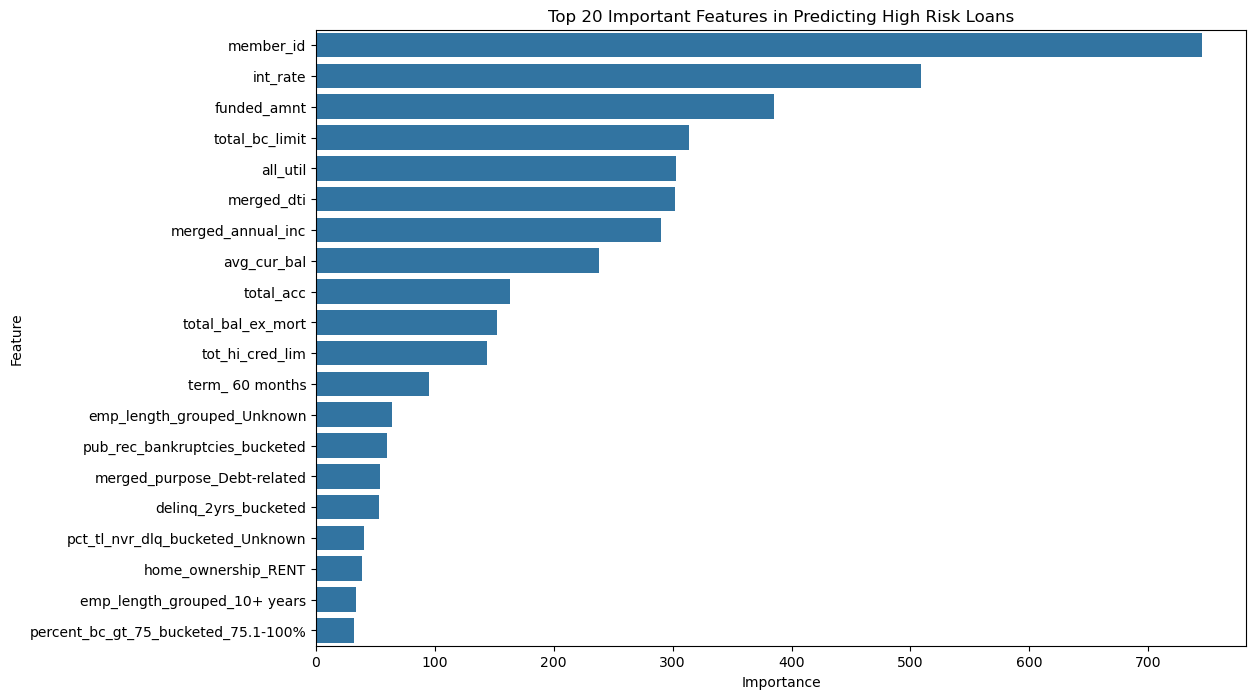

In [ ]:
#Let's try with LightGBM now
# Step 6: Scale Features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 7: Train Model using LightGBM with Balanced Class Weights
!pip install lightgbm
from lightgbm import LGBMClassifier

model = LGBMClassifier(
    n_estimators=150,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    class_weight='balanced'  # Automatically adjusts weights for class imbalance
)

model.fit(X_train_scaled, y_train)

# Step 8: Evaluate the Model
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Step 9: Feature Importance
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

importances = model.feature_importances_
feat_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feat_df.head(20))
plt.title('Top 20 Important Features in Predicting High Risk Loans')
plt.show()


No improvement after these iterations, unfortunately, when trying to predict risky loans. Let's try bucketing the grades column to see if that helps...

In [ ]:
df_subset_two = df_subset.copy()

import pandas as pd

# Example DataFrame
data = {'grade': ['A', 'B', 'C', 'D', 'E', 'F', 'G']}

# Create a new column 'risk_bucket' to classify grades
df_subset_two['risk_bucket'] = df_subset_two['grade'].apply(lambda x: 'Lower Risk' if x in ['A', 'B'] else 'Higher Risk')

In [ ]:
df_subset_two.drop(columns=['grade', "loan_status"], inplace=True)
df_subset_two.set_index('member_id', inplace=True)
df_subset_two.head()

,all_util,avg_cur_bal,delinq_amnt,funded_amnt,home_ownership,int_rate,term,tot_hi_cred_lim,total_acc,total_bal_ex_mort,...,delinq_2yrs_bucketed,accounts_90d_past_due_24m,total_chargeoffs_within_12_mths,open_acc_bucketed,pct_tl_nvr_dlq_bucketed,percent_bc_gt_75_bucketed,pub_rec_bankruptcies_bucketed,loan_status_cleaned,trouble,risk_bucket
member_id,,,,,,,,,,,,,,,,,,,,,
1,28.0,1878.0,0.0,2500,RENT,13.56,36 months,60124.0,34.0,16901.0,...,0,0,0,6-10,100.0,0,1,Current,0,Higher Risk
2,57.0,24763.0,0.0,30000,MORTGAGE,18.94,60 months,372872.0,44.0,99468.0,...,0,0,0,11-15,90-99.9,0,1,Current,0,Higher Risk
3,35.0,18383.0,0.0,5000,MORTGAGE,17.97,36 months,136927.0,13.0,11749.0,...,0,0,0,6-10,100.0,0,0,Current,0,Higher Risk
4,70.0,30505.0,0.0,4000,MORTGAGE,18.94,36 months,385183.0,13.0,36151.0,...,0,0,0,6-10,100.0,75.1-100%,0,Current,0,Higher Risk
5,54.0,9667.0,0.0,30000,MORTGAGE,16.14,60 months,157548.0,26.0,29674.0,...,0,0,0,11-15,90-99.9,0,0,Current,0,Higher Risk


In [ ]:
#Let's try with LightGBM now with bucketed grades

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Split the Data
# Assuming df_subset_two is already defined
X = df_subset_two.drop(columns=['loan_status_cleaned', 'trouble'], axis=1)
y = df_subset_two['trouble']

X = pd.get_dummies(X, drop_first=True)

In [ ]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Step 2: Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

[LightGBM] [Info] Number of positive: 207923, number of negative: 1374544
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.105199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2635
[LightGBM] [Info] Number of data points in the train set: 1582467, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[[375239 213852]
 [ 25947  63163]]
              precision    recall  f1-score   support

           0       0.94      0.64      0.76    589091
           1       0.23      0.71      0.35     89110

    accuracy                           0.65    678201
   macro avg       0.58      0.67      0.55    678201
weighted avg       0.84      0.65      0.70    678201

ROC AUC: 0.7352203307121041


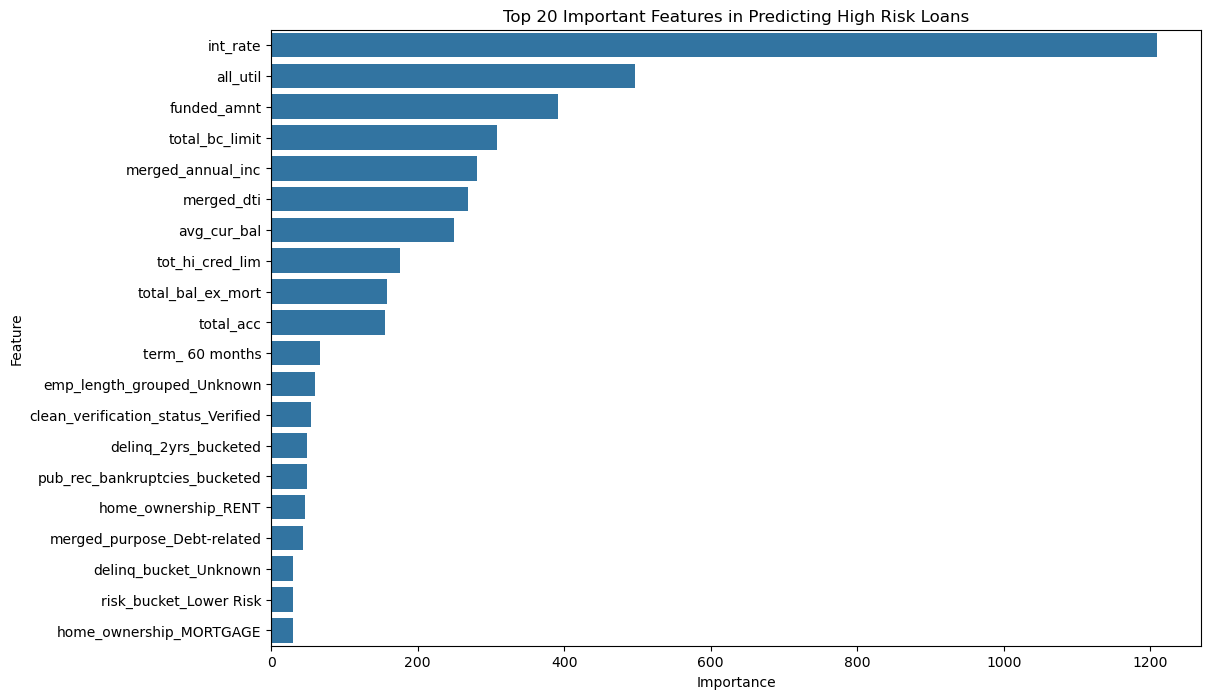

In [ ]:
# Step 3: Train Model using LightGBM with Balanced Class Weights
!pip install lightgbm
from lightgbm import LGBMClassifier

model = LGBMClassifier(
    n_estimators=150,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    class_weight='balanced'  # Automatically adjusts weights for class imbalance
)

model.fit(X_train_scaled, y_train)

# Step 4: Evaluate the Model
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Step 5: Feature Importance
importances = model.feature_importances_
feat_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feat_df.head(20))
plt.title('Top 20 Important Features in Predicting High Risk Loans')
plt.show()

[[334810 254281]
 [ 24597  64513]]
              precision    recall  f1-score   support

           0       0.93      0.57      0.71    589091
           1       0.20      0.72      0.32     89110

    accuracy                           0.59    678201
   macro avg       0.57      0.65      0.51    678201
weighted avg       0.84      0.59      0.65    678201

ROC AUC: 0.7058231989672127


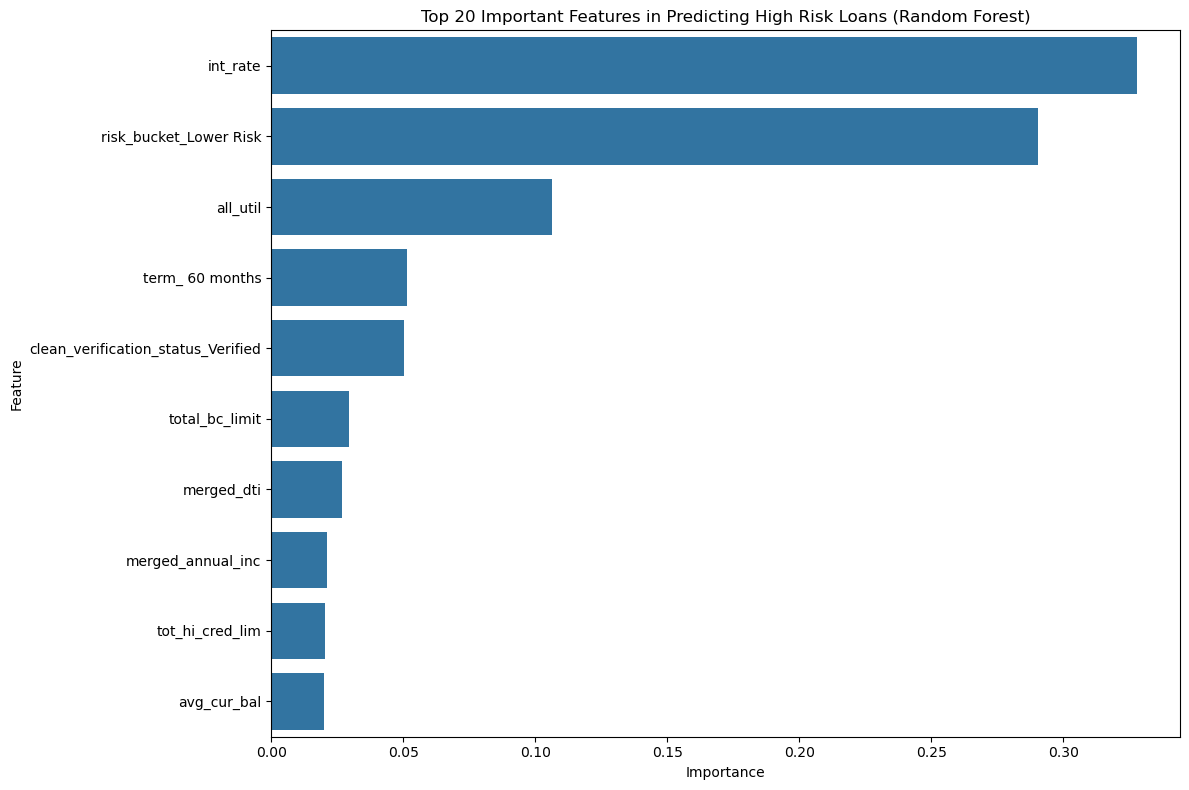

In [ ]:
#Let's see if a different model performs better.

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Initialize Random Forest Model
rf_model = RandomForestClassifier(
    n_estimators=150,
    max_depth=6,
    random_state=42,
    class_weight='balanced',  # Handles class imbalance
    n_jobs=-1  # Uses all available cores for speed
)

# Step 2: Fit the Model
rf_model.fit(X_train_scaled, y_train)

# Step 3: Evaluate the Model
y_pred = rf_model.predict(X_test_scaled)
y_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Step 4: Feature Importance Plot
importances = rf_model.feature_importances_
feat_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feat_df.head(10))
plt.title('Top 20 Important Features in Predicting High Risk Loans (Random Forest)')
plt.tight_layout()
plt.show()


Bucketing did not improve the results. Let's try splitting the data; A-B loans anand C-G loans. We'll create two models to predict trouble for each group.

In [ ]:
df_subset_three = df_subset.copy()

df_subset_three.drop(columns=['loan_status'], inplace=True)

# Example DataFrame
data = {'grade': ['A', 'B', 'C', 'D', 'E', 'F', 'G']}

# Split based on loan grade
df_ab = df_subset_three[df_subset_three['grade'].isin(['A', 'B'])].copy()
df_cg = df_subset_three[df_subset_three['grade'].isin(['C', 'D', 'E', 'F', 'G'])].copy()


In [ ]:
#Step 2: Preprocess each subset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

def preprocess_and_split(df, target_column='trouble', drop_columns=['loan_status_cleaned', 'grade', 'int_rate']):
    # Drop unused or leakage columns
    X = df.drop(columns=drop_columns + [target_column])
    y = df[target_column]

    # One-hot encode categorical features
    X = pd.get_dummies(X, drop_first=True)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

    # Scale numerical features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, X.columns


In [ ]:
# Preprocess A-B loans
X_train_ab, X_test_ab, y_train_ab, y_test_ab, features_ab = preprocess_and_split(df_ab)

# Preprocess C-G loans
X_train_cg, X_test_cg, y_train_cg, y_test_cg, features_cg = preprocess_and_split(df_cg)


In [ ]:
#Step 3 - Train the Random Forest Model

def train_rf_model(X_train_scaled, y_train):
    model = RandomForestClassifier(
        n_estimators=75,
        random_state=78,
        n_jobs=-1
    )
    model.fit(X_train_scaled, y_train)
    return model


In [ ]:
#Step 4 - Evaluate the model

def evaluate_model(model, X_test_scaled, y_test, feature_names):
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

    # Feature importance
    importances = model.feature_importances_
    feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feat_df = feat_df.sort_values(by='Importance', ascending=False)

    import seaborn as sns
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feat_df.head(20))
    plt.title('Top 20 Important Features')
    plt.show()


[[255443      7]
 [ 18696      0]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96    255450
           1       0.00      0.00      0.00     18696

    accuracy                           0.93    274146
   macro avg       0.47      0.50      0.48    274146
weighted avg       0.87      0.93      0.90    274146

ROC AUC Score: 0.6660190299062801


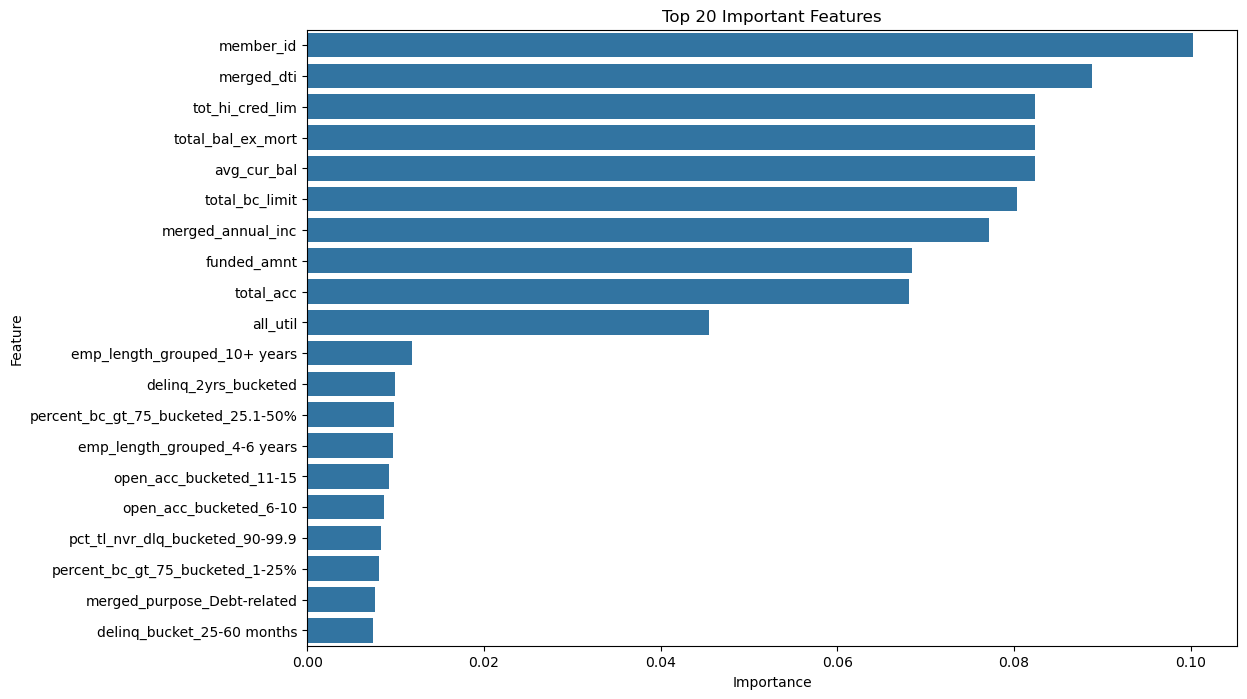

In [ ]:
#Step 5 - Run for each segment

# A-B loans
X_train_ab, X_test_ab, y_train_ab, y_test_ab, features_ab = preprocess_and_split(df_ab)
model_ab = train_rf_model(X_train_ab, y_train_ab)
evaluate_model(model_ab, X_test_ab, y_test_ab, features_ab)


[[234678    781]
 [ 54939    623]]
              precision    recall  f1-score   support

           0       0.81      1.00      0.89    235459
           1       0.44      0.01      0.02     55562

    accuracy                           0.81    291021
   macro avg       0.63      0.50      0.46    291021
weighted avg       0.74      0.81      0.73    291021

ROC AUC Score: 0.6551097049498296


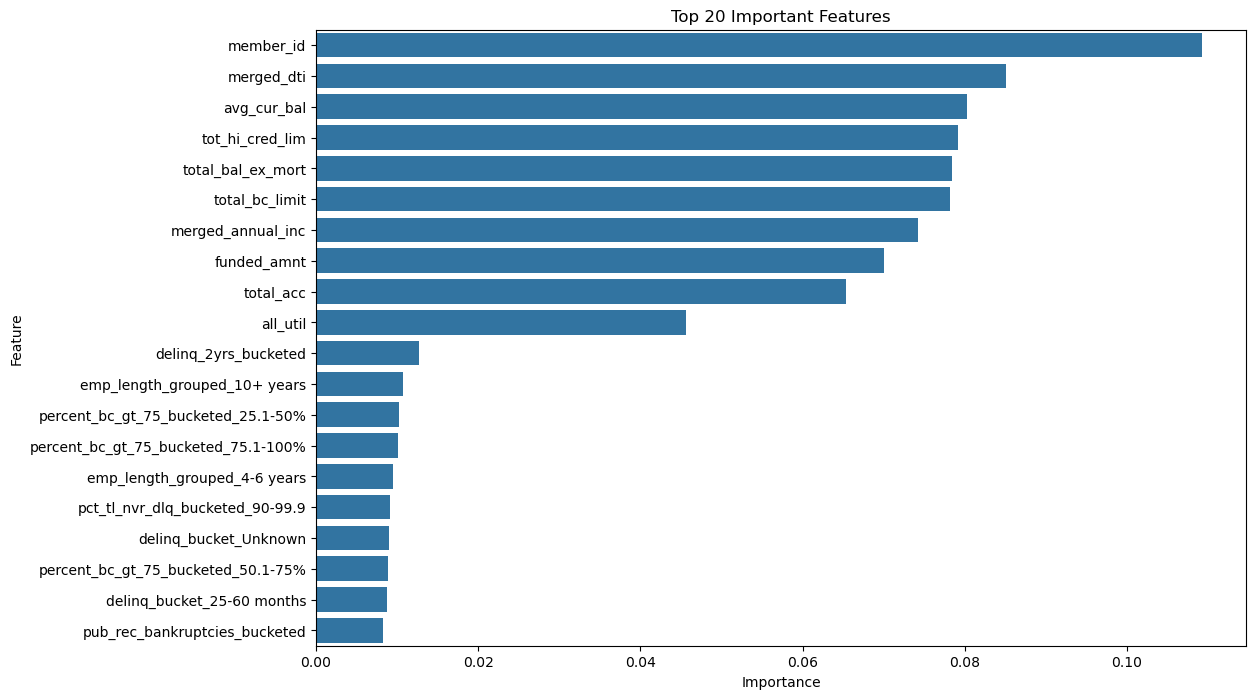

In [ ]:
# C-G loans
X_train_cg, X_test_cg, y_train_cg, y_test_cg, features_cg = preprocess_and_split(df_cg)
model_cg = train_rf_model(X_train_cg, y_train_cg)
evaluate_model(model_cg, X_test_cg, y_test_cg, features_cg)

Unfortunately, none of these techniques / iterations resulted a model with sufficient predictive power for higher risk loans. Class imbalance is a major factor, as evidenced by the improvement in results initially obtained after smoothing/balancing the data.